In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

import warnings
warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE


In [ ]:
!pip install kaggle
#----------------------------
# START get kaggle.json file
!pip install -U -q PyDrive
!pip install -U -q google-auth google-auth-oauthlib google-auth-httplib2

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Set the file ID of the file to be copied
file_link = "https://drive.google.com/file/d/1oobkfPfZBpFE-MZmALTiRxfXjMSjzdpt/view?usp=sharing"
file_id = '1oobkfPfZBpFE-MZmALTiRxfXjMSjzdpt'

# Create a GoogleDriveFile instance with the file ID
file = drive.CreateFile({'id': file_id})

# Download the file to Colab
file.GetContentFile('kaggle.json')

# DONE get kaggle.json file
#----------------------------
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dpl-project-1-dog-breed-identification
# kaggle competitions download -c dog-breed-identification
!mkdir /content/dataset
!unzip -q dpl-project-1-dog-breed-identification.zip -d /content/dataset/dpl-project-1-dog-breed-identification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.8/181.8 kB 4.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.17.3, but you have google-auth 2.22.0 which is incompatible.
 98% 675M/691M [00:09<00:00, 52.1MB/s]
100% 691M/691M [00:09<00:00, 79.3MB/s]


In [ ]:
#from zipfile import ZipFile
#data_path = 'dog-breed-identification.zip'

#with ZipFile(data_path, 'r') as zip:
#	zip.extractall()
#	print('The data set has been extracted.')


In [ ]:
import os
os.chdir('/content/dataset/dpl-project-1-dog-breed-identification')

In [ ]:
df = pd.read_csv('labels.csv')
df.head()


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
df.shape


(10222, 2)

In [ ]:
df['breed'].nunique()


120

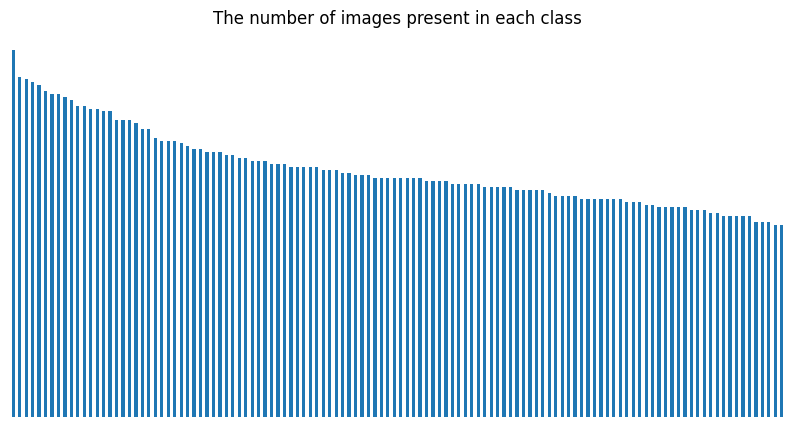

In [ ]:
plt.figure(figsize=(10, 5))
df['breed'].value_counts().plot.bar()
plt.axis('off')
plt.title('The number of images present in each class')
plt.show()


In [ ]:
df['filepath'] = 'train/' + df['id'] + '.jpg'
df.head()


,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


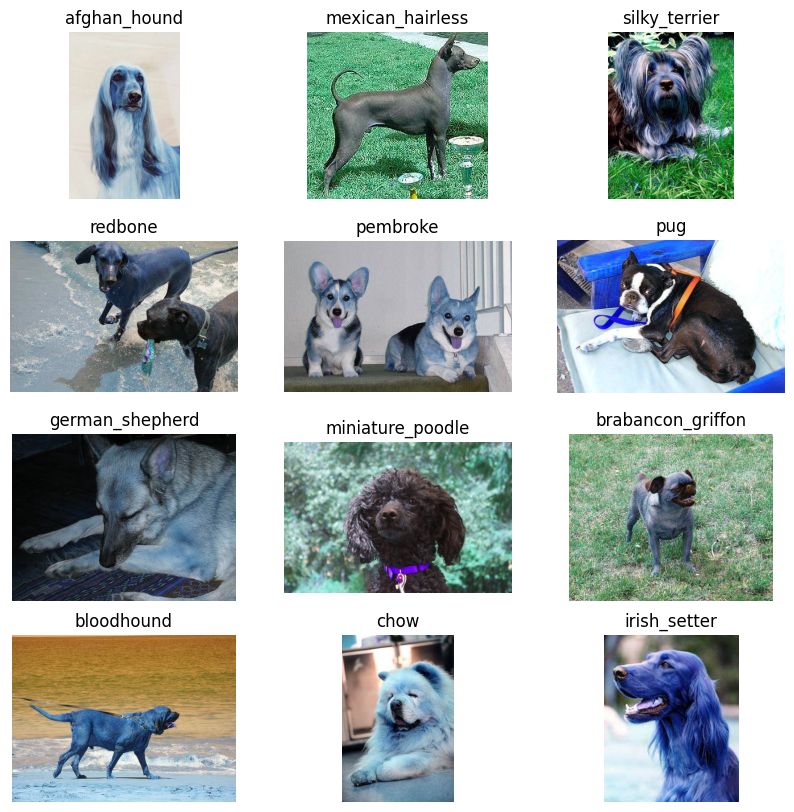

In [ ]:
plt.subplots(figsize=(10, 10))
for i in range(12):
	plt.subplot(4, 3, i+1)

	# Selecting a random image index from the dataframe.
	k = np.random.randint(0, len(df))
	img = cv2.imread(df.loc[k, 'filepath'])
	plt.imshow(img)
	plt.title(df.loc[k, 'breed'])
	plt.axis('off')
plt.show()


In [ ]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()


,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [ ]:
#original_labels = le.inverse_transform(encoded_labels)

In [ ]:
features = df['filepath']
target = df['breed']

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.15,
									random_state=10)

X_train.shape, X_val.shape


((8688,), (1534,))

In [ ]:
import albumentations as A

transforms_train = A.Compose([
	A.VerticalFlip(p=0.2),
	A.HorizontalFlip(p=0.7),
	A.CoarseDropout(p=0.5),
	A.RandomGamma(p=0.5),
	A.RandomBrightnessContrast(p=1)
])


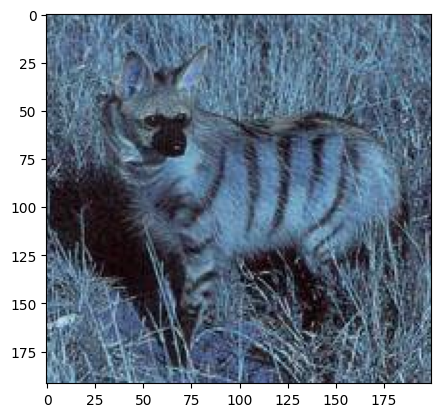

In [ ]:
img = cv2.imread('train/00792e341f3c6eb33663e415d0715370.jpg')
plt.imshow(img)
plt.show()


In [ ]:
augments = [
	A.VerticalFlip(p=0.2),
	A.HorizontalFlip(p=0.7),
	A.CoarseDropout(p=0.5),
	A.RandomGamma(p=0.5),
	A.RandomBrightnessContrast(p=1)
]

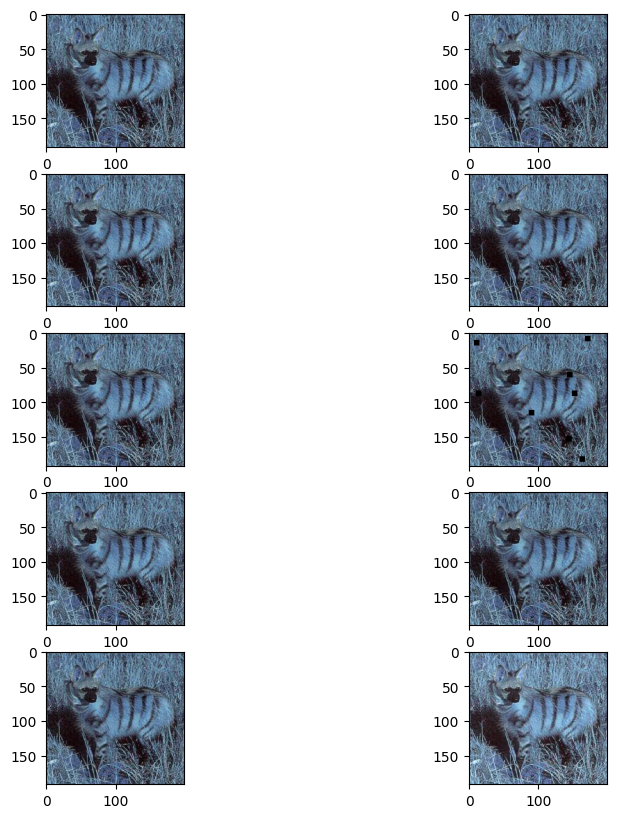

In [ ]:
#augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1), A.CoarseDropout(p=1), A.CLAHE(p=1)]

plt.subplots(figsize=(10, 10))
for i, aug in enumerate(augments):
	plt.subplot(5, 2, 2*i+1)
	plt.imshow(img)
	plt.subplot(5, 2, 2*i+2)
	aug_img = aug(image=img)['image']
	plt.imshow(aug_img)
plt.show()


In [ ]:
def aug_fn(img):
	aug_data = transforms_train(image=img)
	aug_img = aug_data['image']

	return aug_img


@tf.function
def process_data(img, label):
	aug_img = tf.numpy_function(aug_fn,
								[img],
								Tout=tf.float32)

	return img, label


def decode_image(filepath, label=None):
	img = tf.io.read_file(filepath)
	img = tf.image.decode_jpeg(img)
	img = tf.image.resize(img, [128, 128])
	img = tf.cast(img, tf.float32) / 255.0

	if label == None:
		return img

	return img, tf.one_hot(indices=label,
				depth=120,
			 dtype=tf.float32)


In [ ]:
train_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_train, Y_train))
	.map(decode_image, num_parallel_calls=AUTO)
	.map(partial(process_data), num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

val_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_val, Y_val))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)


In [ ]:
for img, label in train_ds.take(1):
  print(img.shape, label.shape)


(32, 128, 128, 3) (32, 120)


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
	input_shape=(128, 128, 3),
	weights='imagenet',
	include_top=False
)


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
len(pre_trained_model.layers)


311

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 6, 6, 768)


In [ ]:
last_output

<KerasTensor: shape=(None, 6, 6, 768) dtype=float32 (created by layer 'mixed7')>

In [ ]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

# Model Compilation
model.compile(
	optimizer='adam',
	loss=keras.losses.CategoricalCrossentropy(from_logits=True),
	metrics=['AUC']
)


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_auc') > 0.99:
			print('\n Validation accuracy has reached upto 99%\
	so, stopping further training.')
			self.model.stop_training = True

es = EarlyStopping(patience=3,
				monitor='val_auc',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [ ]:
history = model.fit(train_ds,
					validation_data=val_ds,
					epochs=50,
					verbose=1,
					callbacks=[es, lr, myCallback()])


Epoch 1/50
272/272 [==============================] - 484s 2s/step - loss: 3.7290 - auc: 0.8219 - val_loss: 2.5780 - val_auc: 0.9375 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - 368s 1s/step - loss: 2.0378 - auc: 0.9687 - val_loss: 2.2999 - val_auc: 0.9464 - lr: 0.0010
Epoch 3/50
272/272 [==============================] - 401s 1s/step - loss: 1.0403 - auc: 0.9938 - val_loss: 2.3510 - val_auc: 0.9320 - lr: 0.0010
Epoch 4/50
272/272 [==============================] - ETA: 0s - loss: 0.4157 - auc: 0.9994
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
272/272 [==============================] - 370s 1s/step - loss: 0.4157 - auc: 0.9994 - val_loss: 2.5312 - val_auc: 0.9141 - lr: 0.0010
Epoch 5/50
272/272 [==============================] - 363s 1s/step - loss: 0.1416 - auc: 1.0000 - val_loss: 2.2968 - val_auc: 0.9265 - lr: 5.0000e-04


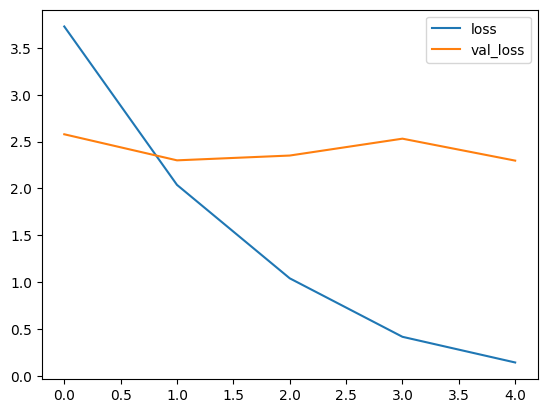

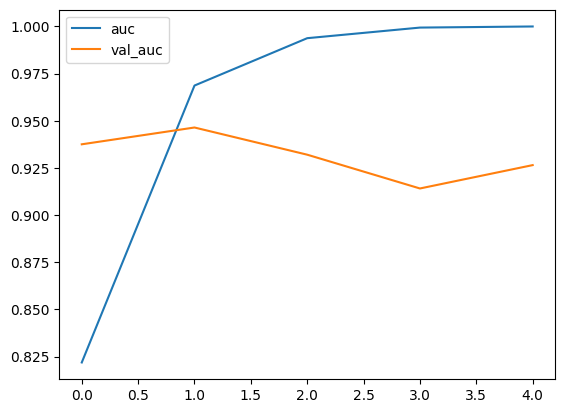

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['auc', 'val_auc']].plot()
plt.show()


**Predict for TEST**

In [ ]:
import os
os.chdir('/content/')

In [ ]:
sm = pd.read_csv('/content/dataset/dpl-project-1-dog-breed-identification/sample_submission.csv')
sm

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10353,fff1ec9e6e413275984966f745a313b0,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10354,fff74b59b758bbbf13a5793182a9bbe4,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
10355,fff7d50d848e8014ac1e9172dc6762a3,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [ ]:
from tqdm.notebook import tqdm
import numpy as np

In [ ]:
folder = "/content/dataset/dpl-project-1-dog-breed-identification/test"
X_test_final = []
ids = []

for img_id in tqdm(sm['id']):
  img = decode_image(folder + '/' + img_id + '.jpg')
  X_test_final.append(img)

X_test_final = np.array(X_test_final)

  0%|          | 0/10357 [00:00<?, ?it/s]

In [ ]:
X_test_final.shape

(10357, 128, 128, 3)

In [ ]:
predictions = model.predict(X_test_final)

324/324 [==============================] - 298s 917ms/step


In [ ]:
import pandas as pd
mySubmission = pd.DataFrame(columns = sm.columns)

mySubmission['id'] = sm['id']

mySubmission.iloc[:,1:] = predictions

mySubmission.to_csv('/content/mySubmission.csv', index=False)

!kaggle competitions submit -c dpl-project-1-dog-breed-identification -f /content/mySubmission.csv -m "Hi mySubmission! chieu 29/07."

100% 26.2M/26.2M [00:03<00:00, 7.37MB/s]
Successfully submitted to DPL / Project 1 / Dog Breed Identification

***Đánh giá mô hình trên dữ liệu kiểm tra :***

In [ ]:
from tqdm.notebook import tqdm

folder = "/content/dataset/dpl-project-1-dog-breed-identification/train"

del X_test_final

X_train = []
#df = pd.read_csv('/content/dataset/dpl-project-1-dog-breed-identification/labels.csv')

for img_id in tqdm(df['id']):
  img = decode_image(folder + '/' + img_id + '.jpg')
  X_train.append(img)

X_train = np.array(X_train)

  0%|          | 0/10222 [00:00<?, ?it/s]

In [ ]:
import numpy as np
from keras.utils import to_categorical

#le = LabelEncoder()
#df['breed'] = le.fit_transform(df['breed'])

y_train = to_categorical(df['breed'], num_classes=120)

In [ ]:
# Đánh giá mô hình trên dữ liệu kiểm tra
evaluation = model.evaluate(X_train, y_train)

# Kết quả đánh giá sẽ chứa giá trị mất mát và các chỉ số đã chọn (ví dụ: độ chính xác)
loss = evaluation[0]
accuracy = evaluation[1]

print("Mất mát trên dữ liệu kiểm tra:", loss)
print("Độ chính xác trên dữ liệu kiểm tra:", accuracy)


# Note: X_test = np.array() of list of image matrices decoded. For e.g.: X_test.shape = (10222, 128, 128, 3)
# Y_one_hot.shape = (10222, 120) for 120 classes

320/320 [==============================] - 292s 912ms/step - loss: 1.1078 - auc: 0.9901
Mất mát trên dữ liệu kiểm tra: 1.1078277826309204
Độ chính xác trên dữ liệu kiểm tra: 0.9900760650634766


__________________________________________________________________________________________________

***Get the actual labels ... (not needed in this project)***

In [ ]:
#softmax_output_np = model.predict(X_test_final)
#argmax_index = np.argmax(softmax_output_np, axis=1)

In [ ]:
#len(argmax_index)

In [ ]:
#y_pred_num = argmax_index

In [ ]:
#classes = pd.read_csv('/content/dataset/dpl-project-1-dog-breed-identification/labels.csv')['breed'].unique().tolist()
#len(classes)

120

In [ ]:

def to_submission(y_pred_num, le, ids, classes, sm):
  import pandas as pd

  prediction = pd.DataFrame()
  prediction['id'] = sm['id']

  encoded_labels = y_pred_num

  original_labels = le.inverse_transform(encoded_labels)

  prediction['breed'] = original_labels

  end_index = len(prediction) - 1
  #end_index = 10356
  num_classes = len(classes)
  for i in range(num_classes):
    prediction.loc[end_index+1+i,'breed'] = classes[i]
  dummies = pd.get_dummies(prediction['breed'])
  prediction = pd.concat([prediction, dummies], axis=1)
  prediction.drop(prediction.index[end_index+1:len(prediction)], inplace=True)
  prediction.drop(['breed'], axis=1,inplace=True)

  #prediction.insert(0, 'id', sm['id']) # Insert the column id from the sample_submission at the start of the data frame
  submission = prediction
  submission.to_csv('/content/submission.csv', index=False)
  print('Successfully.')
  # !kaggle competitions submit -c dpl-project-1-dog-breed-identification -f /content/submission.csv -m "Message"


In [ ]:
#to_submission(y_pred_num, le, ids, classes, sm)

Successfully.


In [ ]:
#sub = pd.read_csv('/content/submission.csv')
#sub

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00102ee9d8eb90812350685311fe5890,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0012a730dfa437f5f3613fb75efcd4ce,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,001510bc8570bbeee98c8d80c8a95ec1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001a5f3114548acdefa3d4da05474c2e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10353,fff1ec9e6e413275984966f745a313b0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10354,fff74b59b758bbbf13a5793182a9bbe4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10355,fff7d50d848e8014ac1e9172dc6762a3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#!kaggle competitions submit -c dpl-project-1-dog-breed-identification -f /content/submission.csv -m "Hi there! t"

100% 2.70M/2.70M [00:03<00:00, 720kB/s] 
Successfully submitted to DPL / Project 1 / Dog Breed Identification

In [ ]:
import numpy as np
import tensorflow as tf
import keras
#model = ...  # Get model (Sequential, Functional Model, or Model subclass)
#model.save('/content/mymodel.keras')  # The file needs to end with the .keras extension
#model2 = keras.models.load_model('/content/mymodel.keras')

In [ ]:
#import pandas as pd
#df = pd.read_csv('/content/dataset/dpl-project-1-dog-breed-identification/labels.csv')